In [37]:
import pandas as pd
import numpy as np
from scipy.stats import skew
from scipy.stats import spearmanr

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet, LassoLars
from sklearn.svm import SVR

from xgboost import XGBRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
import catboost
from catboost import CatBoostRegressor

from supervised.automl import AutoML

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt # seaborn figure 크기 조절을 위해서
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
# 운영체제별 한글 폰트 설정
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정
# 글씨 선명하게 출력하는 설정
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

SEED = 2
np.random.seed(SEED)

# 건물유형별 에너지소비 예측성능 향상을 위한 변수중요도 및 기계학습모델 평가 p.6 CVRMSE
def cvrmse_score(y_true, y_pred):
    return ((np.sqrt(mean_squared_error(y_true, y_pred))) / y_true.mean() ) * 100 

In [38]:
train_df = pd.read_csv('data/train_df.csv', index_col=0)
test_df = pd.read_csv('data/test_df.csv', index_col=0)
train_df.useDate = pd.to_datetime(train_df.useDate)
train_df.date = pd.to_datetime(train_df.date)
test_df.useDate = pd.to_datetime(test_df.useDate)
test_df.date = pd.to_datetime(test_df.date)

# ML

## DV_N

In [39]:
DV = 'N'

## Operating

### Y

In [40]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6240 entries, 576 to 6815
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   useDate    6240 non-null   datetime64[ns]
 1   useType    6240 non-null   object        
 2   toeQty     6240 non-null   float64       
 3   date       6240 non-null   datetime64[ns]
 4   month      6240 non-null   int64         
 5   day        6240 non-null   int64         
 6   hour       6240 non-null   int64         
 7   weekday    6240 non-null   int64         
 8   holiday    6240 non-null   int64         
 9   temp       6240 non-null   float64       
 10  rain       6240 non-null   float64       
 11  wind       6240 non-null   float64       
 12  hum        6240 non-null   int64         
 13  ss         6240 non-null   float64       
 14  sr         6240 non-null   float64       
 15  operating  6240 non-null   int64         
dtypes: datetime64[ns](2), float64(6), int64(7), o

In [41]:
Operating_yn = 1

In [42]:
train_df = train_df[train_df.operating == Operating_yn]
test_df = test_df[test_df.operating == Operating_yn]

##### 상관계수

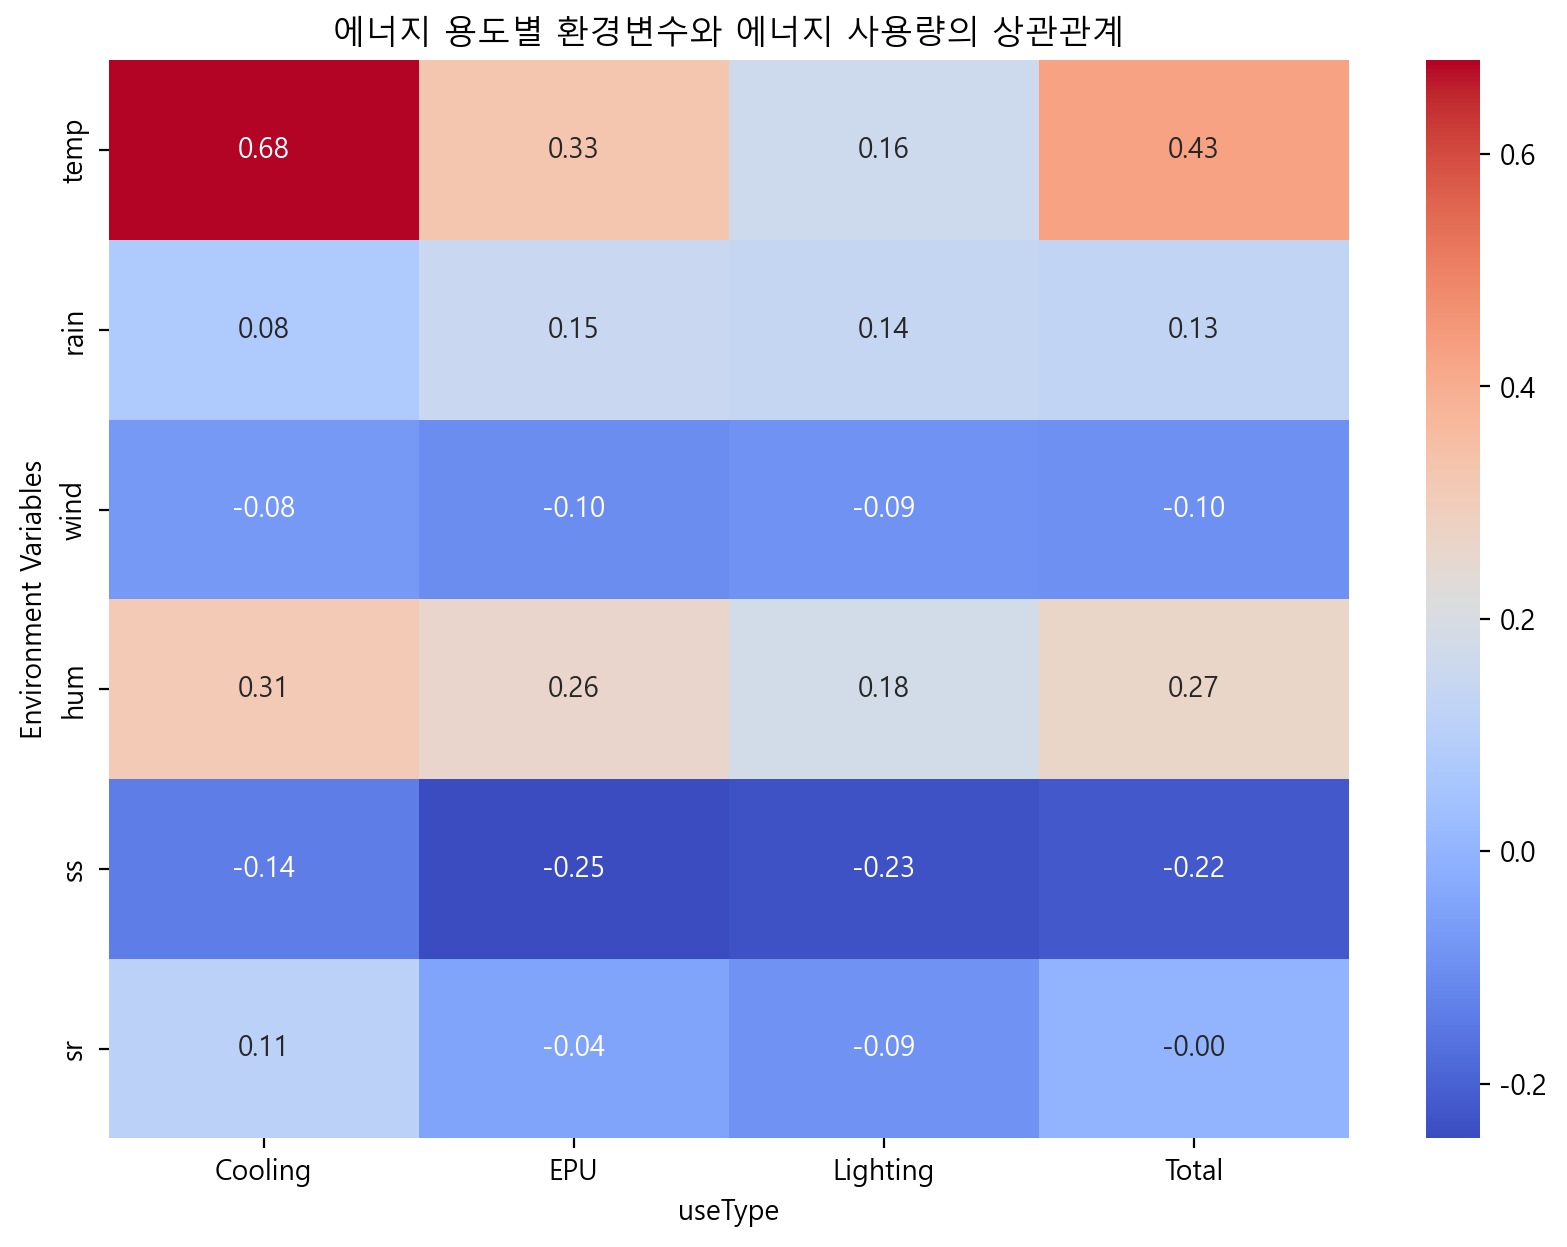

In [43]:
corrs = []
for x in train_df.useType.unique():
    corr = []
    corr.append(x)
    for feat in ['temp', 'rain', 'wind', 'hum', 'ss', 'sr']:
        corr.append(spearmanr(train_df.loc[train_df.useType == x, feat], train_df.loc[train_df.useType == x, 'toeQty']).correlation)
    corrs.append(corr)
    
corr_df = pd.DataFrame(np.array(corrs), columns =  ['useType', 'temp', 'rain', 'wind', 'hum', 'ss', 'sr'])
corr_df.set_index('useType', inplace=True)
corr_df = corr_df.transpose()
corr_df = corr_df.apply(pd.to_numeric, errors='coerce')

plt.figure(figsize=(10, 7))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('에너지 용도별 환경변수와 에너지 사용량의 상관관계')
plt.xlabel('useType')
plt.ylabel('Environment Variables')
plt.show()

#### 전체 - CV(RMSE) SCORE: 26.745063922742723

In [44]:
xxx = 'Total'

##### train, test set 

In [45]:
globals()['y_train_{}'.format(xxx)] = train_df[train_df.useType == f'{xxx}']['toeQty']
globals()['X_train_{}'.format(xxx)] = train_df.drop(['toeQty'], axis=1)
globals()['X_train_{}'.format(xxx)] = globals()['X_train_{}'.format(xxx)][globals()['X_train_{}'.format(xxx)].useType == f'{xxx}']
globals()['X_train_{}'.format(xxx)].drop(['useType', 'useDate', 'date', 'month', 'day'], axis=1, inplace=True)

globals()['y_test_{}'.format(xxx)] = test_df[test_df.useType == f'{xxx}']['toeQty']
globals()['X_test_{}'.format(xxx)] = test_df.drop(['toeQty'], axis=1)
globals()['X_test_{}'.format(xxx)] = globals()['X_test_{}'.format(xxx)][globals()['X_test_{}'.format(xxx)].useType == f'{xxx}']
globals()['X_test_{}'.format(xxx)].drop(['useType', 'useDate', 'date', 'month', 'day'], axis=1, inplace=True)
test_useDate = test_df[test_df.useType == f'{xxx}']['useDate']

##### importance

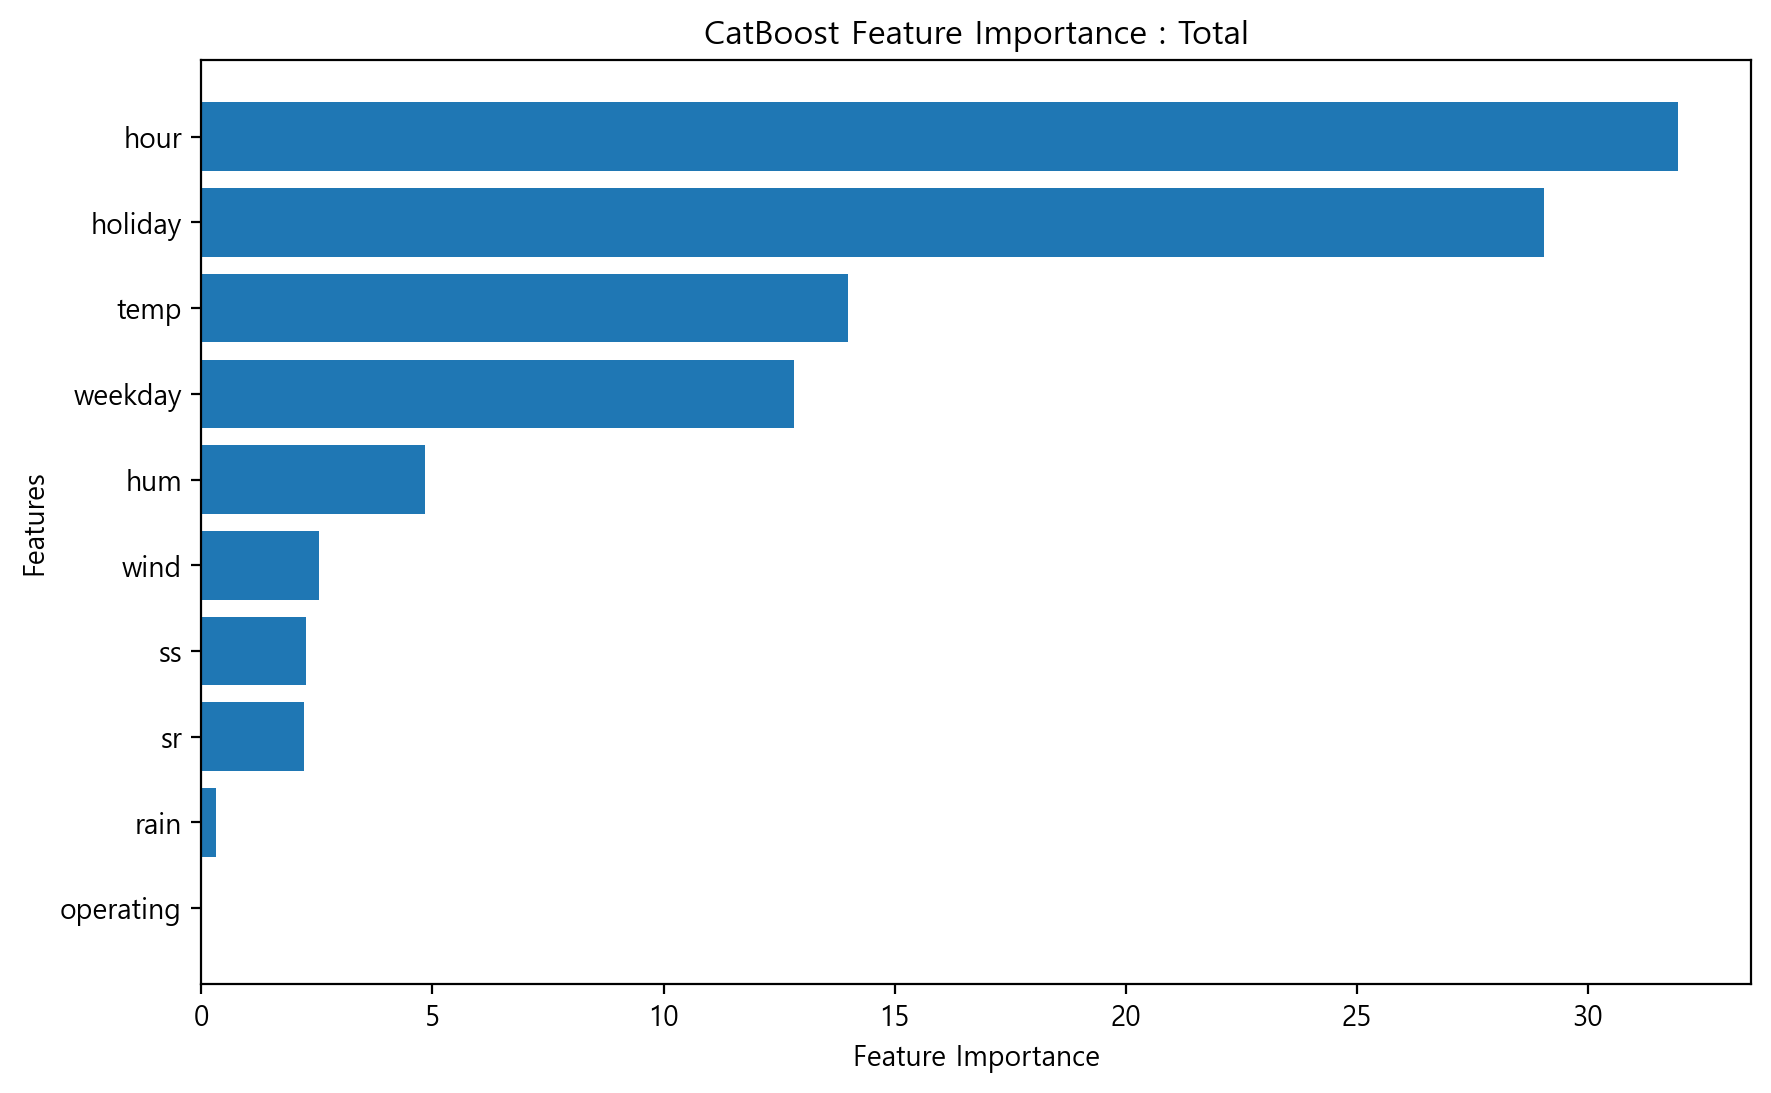

In [46]:
# CatBoostRegressor 모델 초기화
tree_model = CatBoostRegressor(random_state=SEED, verbose=False)

# 모델을 학습 데이터로 학습
tree_model.fit(globals()['X_train_{}'.format(xxx)], globals()['y_train_{}'.format(xxx)])

# 피처 중요도를 얻어옴
feature_importance = tree_model.get_feature_importance()

# 피처명을 가져옴
feature_names = globals()['X_train_{}'.format(xxx)].columns

# 중요도를 데이터프레임으로 변환
fi_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})

# 중요도를 기준으로 내림차순 정렬
fi_df = fi_df.sort_values(by='importance', ascending=False)

# 중요도를 시각화
plt.figure(figsize=(10, 6))
plt.barh(fi_df['feature'], fi_df['importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title(f'CatBoost Feature Importance : {xxx}')
plt.gca().invert_yaxis()  # 중요도가 높은 피처가 위로 오도록 뒤집음
plt.show()


##### ML

###### MODEL

In [47]:
globals()['automl_{}'.format(xxx)]  = AutoML(mode="Perform", 
                                             algorithms=["CatBoost", "Xgboost", "LightGBM"],
                                             results_path=f"model/DV_{DV}/op_{Operating_yn}/{xxx}",
                                             eval_metric='rmse',
                                             explain_level=0)
globals()['automl_{}'.format(xxx)].fit(globals()['X_train_{}'.format(xxx)], globals()['y_train_{}'.format(xxx)])

This model has already been fitted. You can use predict methods or select a new 'results_path' for a new 'fit()'.


###### CV(RMSE) SCORE

In [48]:
globals()['pred_{}'.format(xxx)] = globals()['automl_{}'.format(xxx)].predict(globals()['X_test_{}'.format(xxx)])
print(f"CV(RMSE) SCORE: {cvrmse_score(globals()['y_test_{}'.format(xxx)], globals()['pred_{}'.format(xxx)])}")

CV(RMSE) SCORE: 19.983887333893588


###### Actual VS Predict lineplot

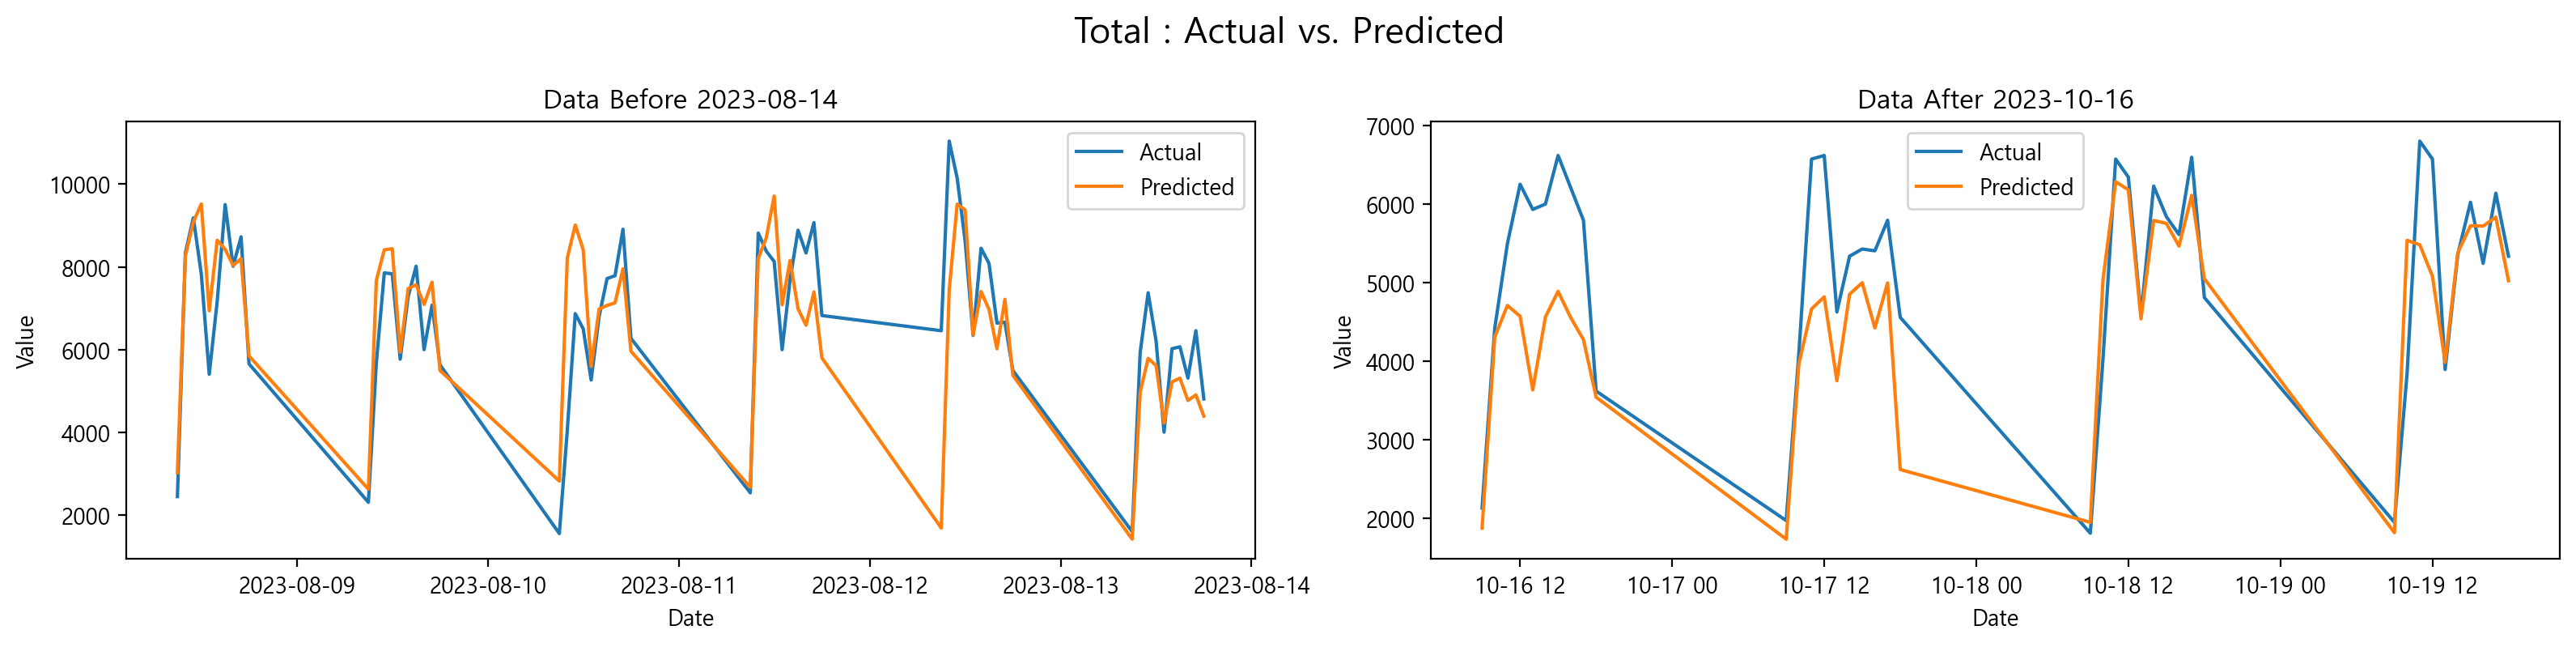

In [49]:
result_df = pd.DataFrame({'useDate': test_useDate, '실제': globals()['y_test_{}'.format(xxx)], '예측': globals()['pred_{}'.format(xxx)]})
before_df = result_df[result_df['useDate'] < '2023-08-15']
after_df = result_df[result_df['useDate'] > '2023-10-16']

Totalfig, axes = plt.subplots(1, 2, figsize=(16 , 4))

axes[0].plot(before_df['useDate'], before_df['실제'], label='Actual')
axes[0].plot(before_df['useDate'], before_df['예측'], label='Predicted')
axes[0].set_title('Data Before 2023-08-14')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Value')
axes[0].legend()

axes[1].plot(after_df['useDate'], after_df['실제'], label='Actual')
axes[1].plot(after_df['useDate'], after_df['예측'], label='Predicted')
axes[1].set_title('Data After 2023-10-16')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Value')
axes[1].legend()

Totalfig.suptitle(f'{xxx} : Actual vs. Predicted', fontsize=16)
plt.tight_layout()
plt.show()


#### 냉방 - CV(RMSE) SCORE: 75.36374241623854

In [50]:
xxx = 'Cooling'

##### train, test set 

In [51]:
globals()['y_train_{}'.format(xxx)] = train_df[train_df.useType == f'{xxx}']['toeQty']
globals()['X_train_{}'.format(xxx)] = train_df.drop(['toeQty'], axis=1)
globals()['X_train_{}'.format(xxx)] = globals()['X_train_{}'.format(xxx)][globals()['X_train_{}'.format(xxx)].useType == f'{xxx}']
globals()['X_train_{}'.format(xxx)].drop(['useType', 'useDate', 'date', 'month', 'day'], axis=1, inplace=True)

globals()['y_test_{}'.format(xxx)] = test_df[test_df.useType == f'{xxx}']['toeQty']
globals()['X_test_{}'.format(xxx)] = test_df.drop(['toeQty'], axis=1)
globals()['X_test_{}'.format(xxx)] = globals()['X_test_{}'.format(xxx)][globals()['X_test_{}'.format(xxx)].useType == f'{xxx}']
globals()['X_test_{}'.format(xxx)].drop(['useType', 'useDate', 'date', 'month', 'day'], axis=1, inplace=True)
test_useDate = test_df[test_df.useType == f'{xxx}']['useDate']

##### importance

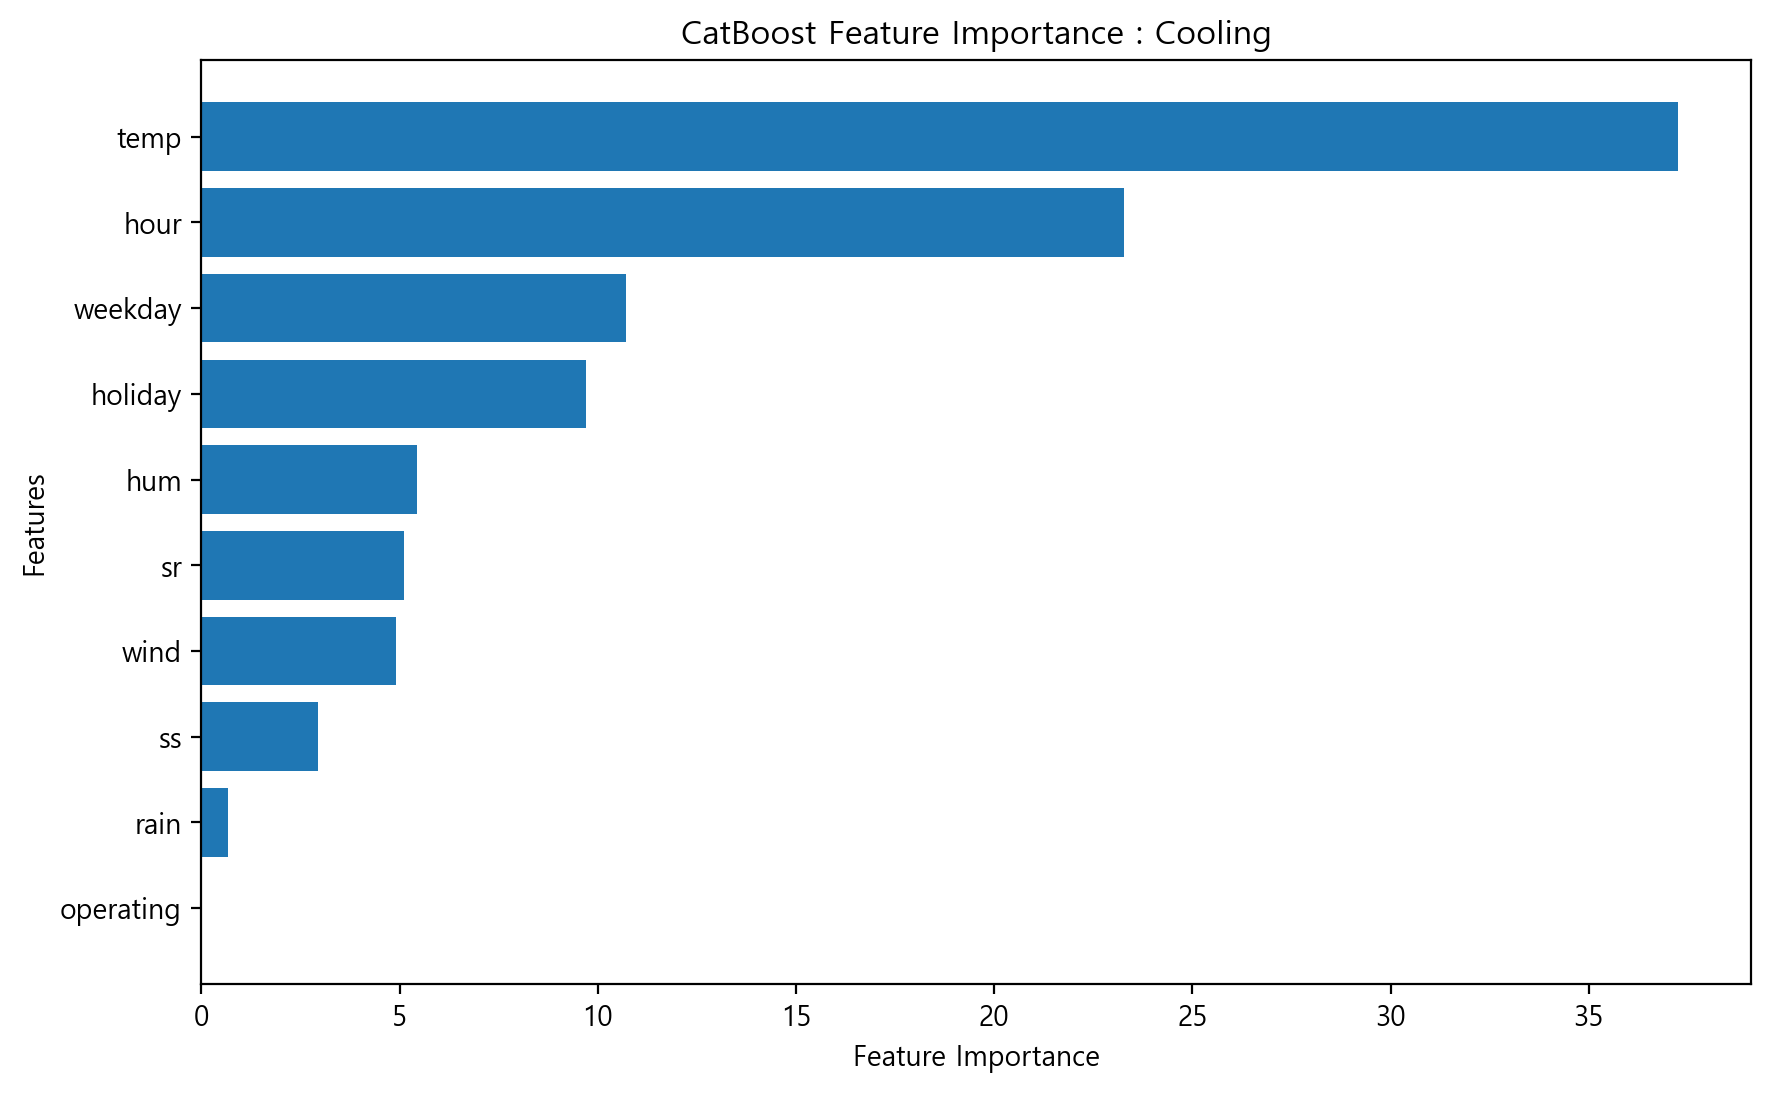

In [52]:
# CatBoostRegressor 모델 초기화
tree_model = CatBoostRegressor(random_state=SEED, verbose=False)

# 모델을 학습 데이터로 학습
tree_model.fit(globals()['X_train_{}'.format(xxx)], globals()['y_train_{}'.format(xxx)])

# 피처 중요도를 얻어옴
feature_importance = tree_model.get_feature_importance()

# 피처명을 가져옴
feature_names = globals()['X_train_{}'.format(xxx)].columns

# 중요도를 데이터프레임으로 변환
fi_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})

# 중요도를 기준으로 내림차순 정렬
fi_df = fi_df.sort_values(by='importance', ascending=False)

# 중요도를 시각화
plt.figure(figsize=(10, 6))
plt.barh(fi_df['feature'], fi_df['importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title(f'CatBoost Feature Importance : {xxx}')
plt.gca().invert_yaxis()  # 중요도가 높은 피처가 위로 오도록 뒤집음
plt.show()


##### ML

###### MODEL

In [53]:
globals()['automl_{}'.format(xxx)] = AutoML(mode="Perform",
                                            algorithms=["CatBoost", "Xgboost", "LightGBM"],
                                            results_path=f"model/DV_{DV}/op_{Operating_yn}/{xxx}",
                                            eval_metric='rmse',
                                            explain_level=0)
globals()['automl_{}'.format(xxx)].fit(globals()['X_train_{}'.format(xxx)], globals()['y_train_{}'.format(xxx)])

This model has already been fitted. You can use predict methods or select a new 'results_path' for a new 'fit()'.


###### CV(RMSE) SCORE

In [54]:
globals()['pred_{}'.format(xxx)] = globals()['automl_{}'.format(xxx)].predict(globals()['X_test_{}'.format(xxx)])
print(f"CV(RMSE) SCORE: {cvrmse_score(globals()['y_test_{}'.format(xxx)], globals()['pred_{}'.format(xxx)])}")

CV(RMSE) SCORE: 55.26584687398818


###### Actual VS Predict lineplot

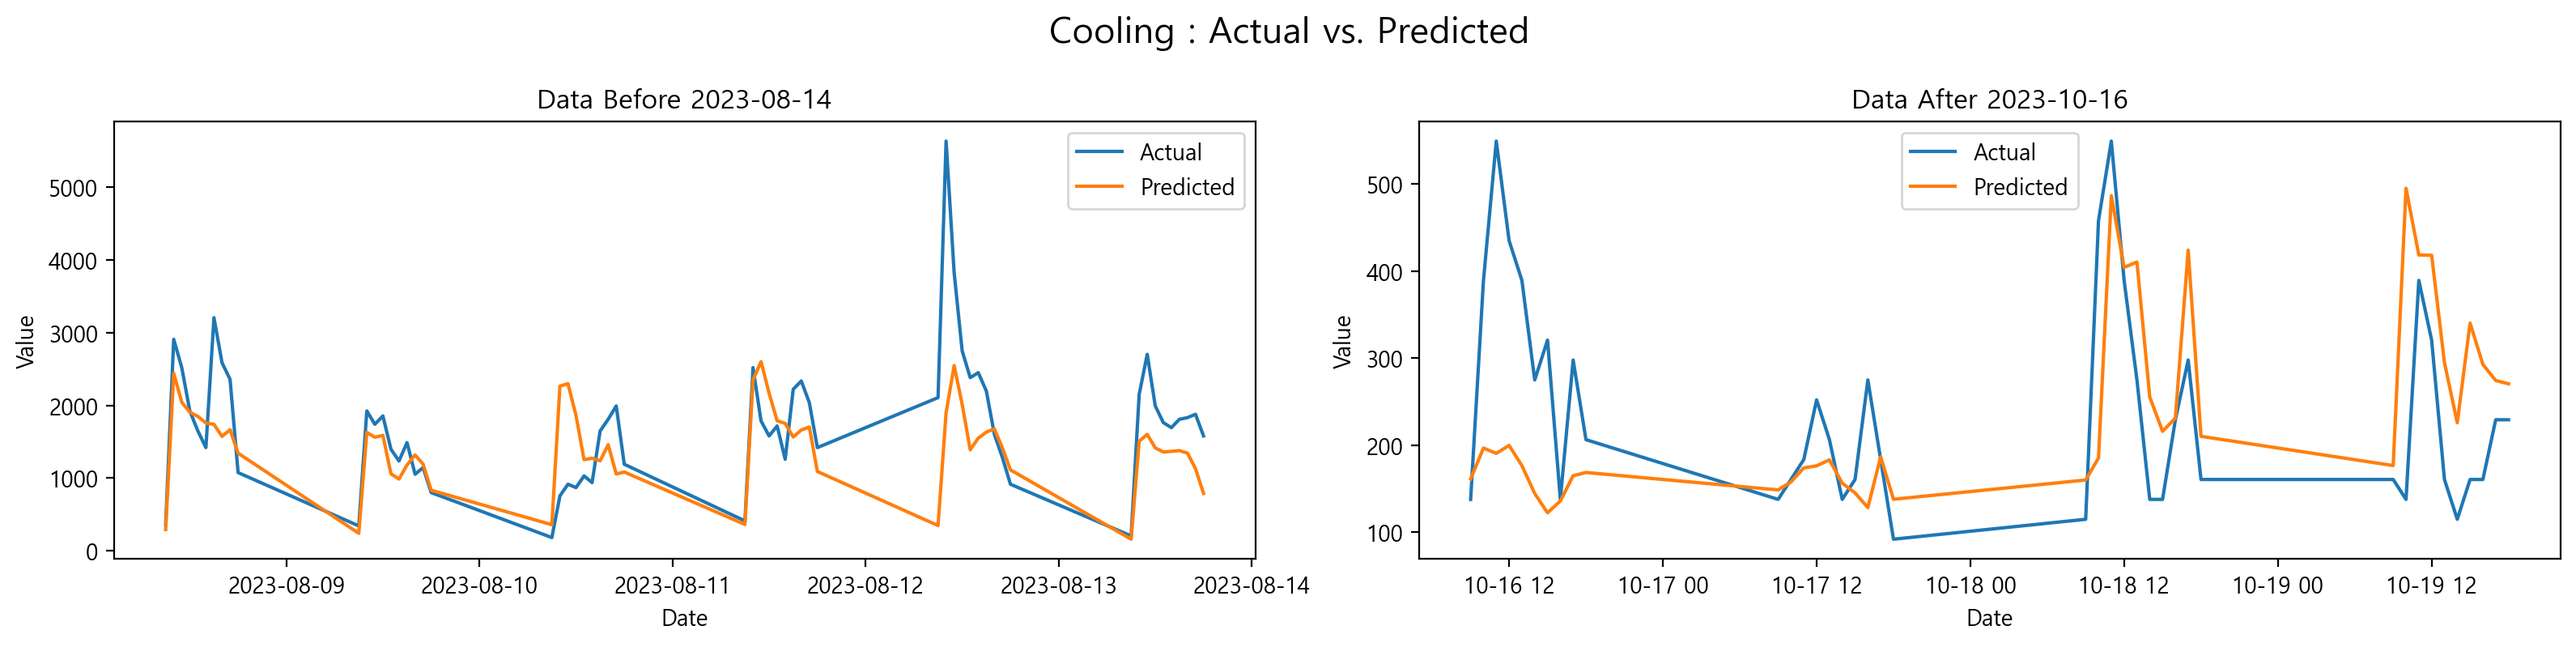

In [55]:
result_df = pd.DataFrame({'useDate': test_useDate, '실제': globals()['y_test_{}'.format(xxx)], '예측': globals()['pred_{}'.format(xxx)]})
before_df = result_df[result_df['useDate'] < '2023-08-15']
after_df = result_df[result_df['useDate'] > '2023-10-16']

Totalfig, axes = plt.subplots(1, 2, figsize=(16 , 4))

axes[0].plot(before_df['useDate'], before_df['실제'], label='Actual')
axes[0].plot(before_df['useDate'], before_df['예측'], label='Predicted')
axes[0].set_title('Data Before 2023-08-14')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Value')
axes[0].legend()

axes[1].plot(after_df['useDate'], after_df['실제'], label='Actual')
axes[1].plot(after_df['useDate'], after_df['예측'], label='Predicted')
axes[1].set_title('Data After 2023-10-16')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Value')
axes[1].legend()

Totalfig.suptitle(f'{xxx} : Actual vs. Predicted', fontsize=16)
plt.tight_layout()
plt.show()


#### 조명 - CV(RMSE) SCORE: 28.09388899780324

In [56]:
xxx = 'Lighting'

##### train, test set 

In [57]:
globals()['y_train_{}'.format(xxx)] = train_df[train_df.useType == f'{xxx}']['toeQty']
globals()['X_train_{}'.format(xxx)] = train_df.drop(['toeQty'], axis=1)
globals()['X_train_{}'.format(xxx)] = globals()['X_train_{}'.format(xxx)][globals()['X_train_{}'.format(xxx)].useType == f'{xxx}']
globals()['X_train_{}'.format(xxx)].drop(['useType', 'useDate', 'date', 'month', 'day'], axis=1, inplace=True)

globals()['y_test_{}'.format(xxx)] = test_df[test_df.useType == f'{xxx}']['toeQty']
globals()['X_test_{}'.format(xxx)] = test_df.drop(['toeQty'], axis=1)
globals()['X_test_{}'.format(xxx)] = globals()['X_test_{}'.format(xxx)][globals()['X_test_{}'.format(xxx)].useType == f'{xxx}']
globals()['X_test_{}'.format(xxx)].drop(['useType', 'useDate', 'date', 'month', 'day'], axis=1, inplace=True)
test_useDate = test_df[test_df.useType == f'{xxx}']['useDate']

##### importance

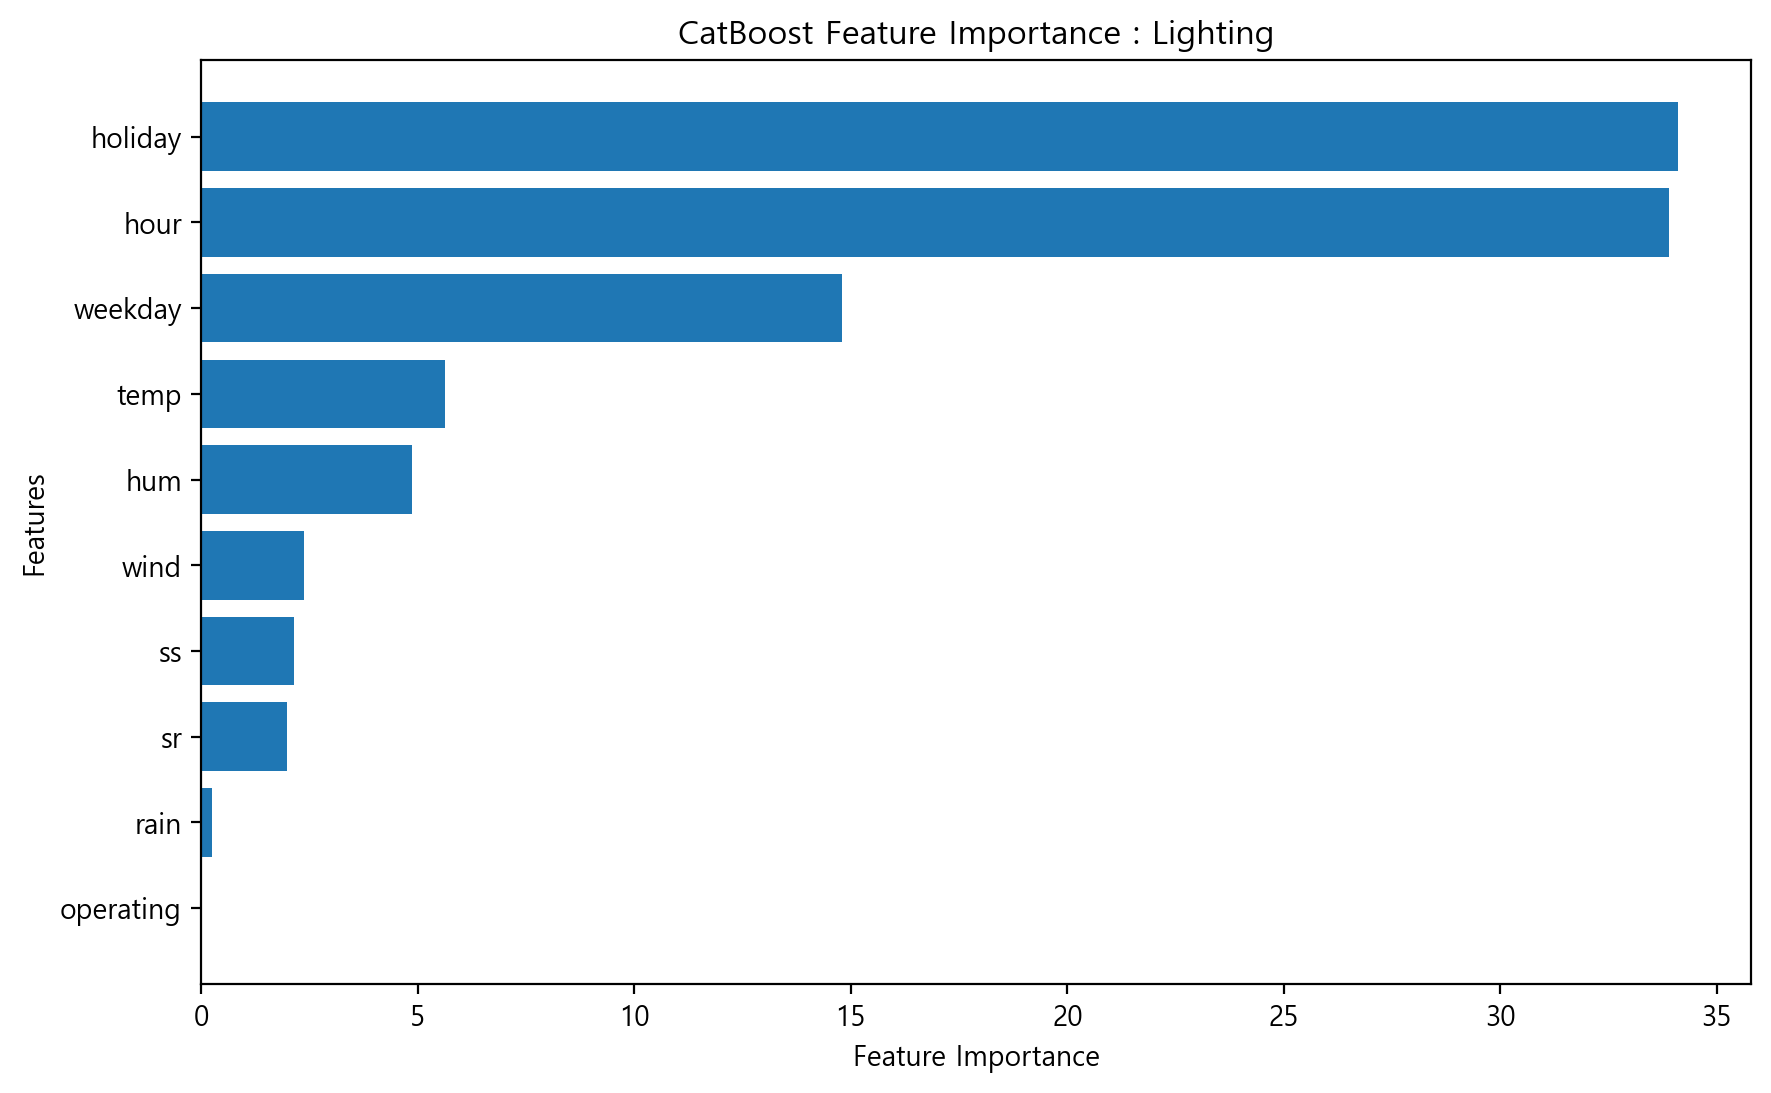

In [58]:
# CatBoostRegressor 모델 초기화
tree_model = CatBoostRegressor(random_state=SEED, verbose=False)

# 모델을 학습 데이터로 학습
tree_model.fit(globals()['X_train_{}'.format(xxx)], globals()['y_train_{}'.format(xxx)])

# 피처 중요도를 얻어옴
feature_importance = tree_model.get_feature_importance()

# 피처명을 가져옴
feature_names = globals()['X_train_{}'.format(xxx)].columns

# 중요도를 데이터프레임으로 변환
fi_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})

# 중요도를 기준으로 내림차순 정렬
fi_df = fi_df.sort_values(by='importance', ascending=False)

# 중요도를 시각화
plt.figure(figsize=(10, 6))
plt.barh(fi_df['feature'], fi_df['importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title(f'CatBoost Feature Importance : {xxx}')
plt.gca().invert_yaxis()  # 중요도가 높은 피처가 위로 오도록 뒤집음
plt.show()


##### ML

###### MODEL

In [59]:
globals()['automl_{}'.format(xxx)] = AutoML(mode="Perform",
                                            algorithms=["CatBoost", "Xgboost", "LightGBM"],
                                            results_path=f"model/DV_{DV}/op_{Operating_yn}/{xxx}",
                                            eval_metric='rmse',
                                            explain_level=0)
globals()['automl_{}'.format(xxx)].fit(globals()['X_train_{}'.format(xxx)], globals()['y_train_{}'.format(xxx)])

This model has already been fitted. You can use predict methods or select a new 'results_path' for a new 'fit()'.


###### CV(RMSE) SCORE

In [60]:
globals()['pred_{}'.format(xxx)] = globals()['automl_{}'.format(xxx)].predict(globals()['X_test_{}'.format(xxx)])
print(f"CV(RMSE) SCORE: {cvrmse_score(globals()['y_test_{}'.format(xxx)], globals()['pred_{}'.format(xxx)])}")

CV(RMSE) SCORE: 19.560870532559047


###### Actual VS Predict lineplot

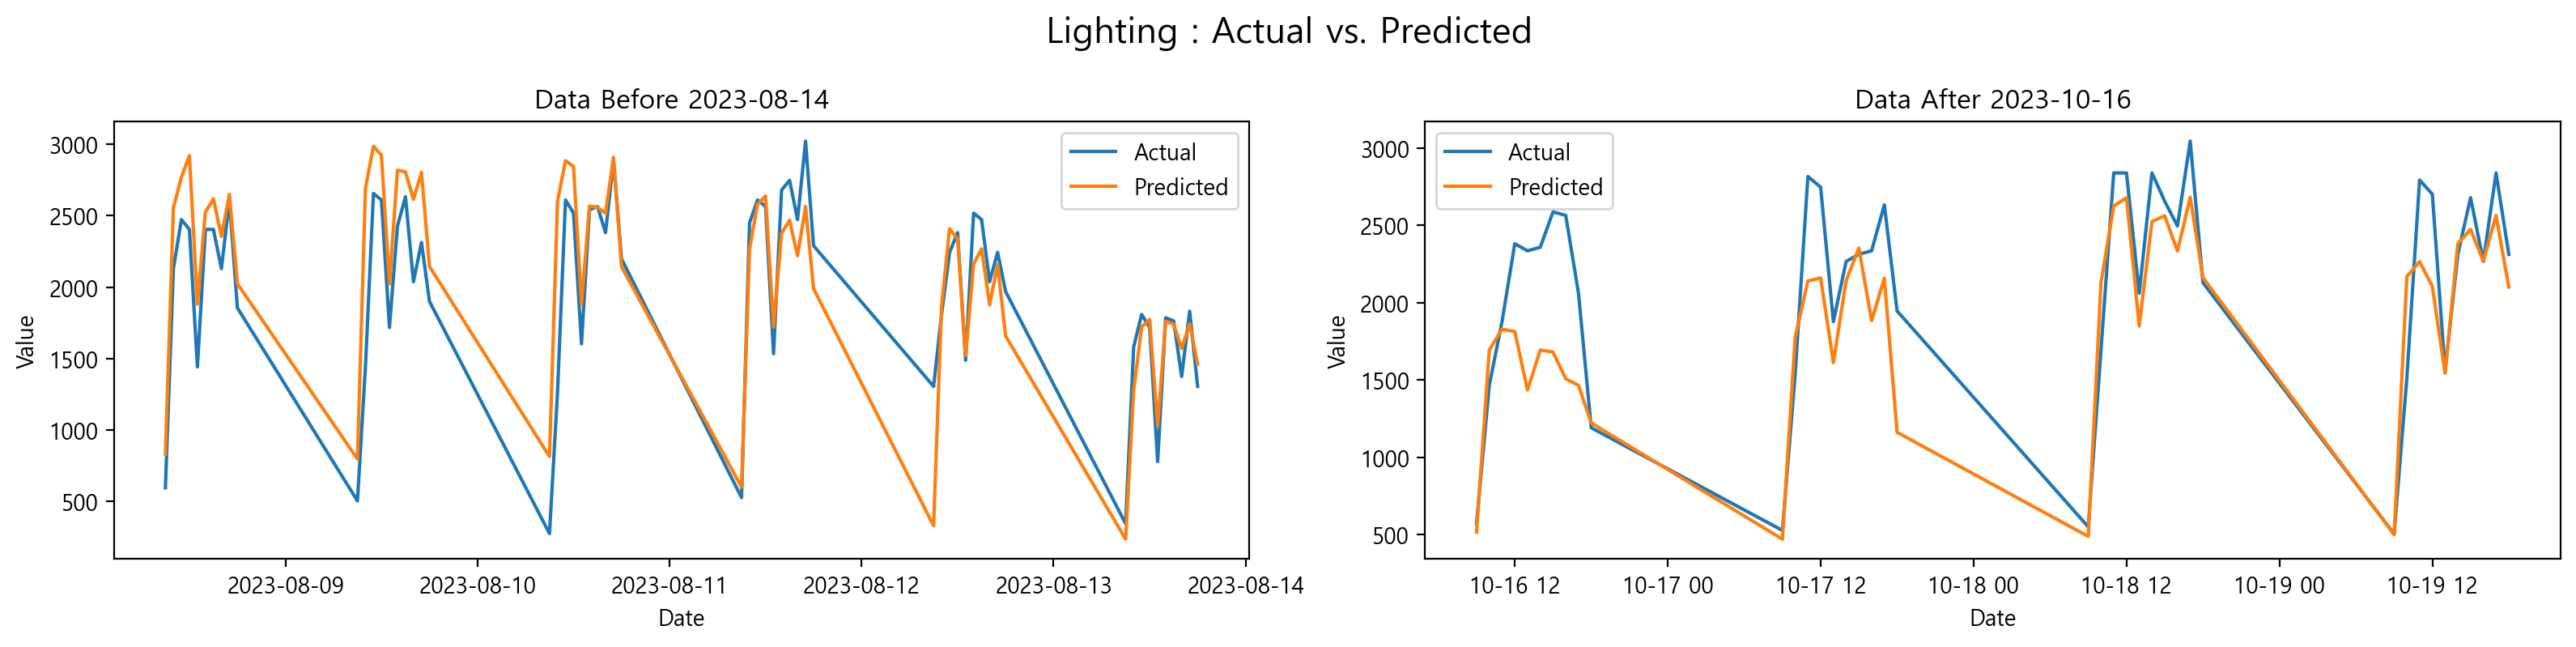

In [61]:
result_df = pd.DataFrame({'useDate': test_useDate, '실제': globals()['y_test_{}'.format(xxx)], '예측': globals()['pred_{}'.format(xxx)]})
before_df = result_df[result_df['useDate'] < '2023-08-15']
after_df = result_df[result_df['useDate'] > '2023-10-16']

Totalfig, axes = plt.subplots(1, 2, figsize=(16 , 4))

axes[0].plot(before_df['useDate'], before_df['실제'], label='Actual')
axes[0].plot(before_df['useDate'], before_df['예측'], label='Predicted')
axes[0].set_title('Data Before 2023-08-14')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Value')
axes[0].legend()

axes[1].plot(after_df['useDate'], after_df['실제'], label='Actual')
axes[1].plot(after_df['useDate'], after_df['예측'], label='Predicted')
axes[1].set_title('Data After 2023-10-16')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Value')
axes[1].legend()

Totalfig.suptitle(f'{xxx} : Actual vs. Predicted', fontsize=16)
plt.tight_layout()
plt.show()


#### 전열 - CV(RMSE) SCORE: 21.253514368461136

In [62]:
xxx = 'EPU'

##### train, test set 

In [63]:
globals()['y_train_{}'.format(xxx)] = train_df[train_df.useType == f'{xxx}']['toeQty']
globals()['X_train_{}'.format(xxx)] = train_df.drop(['toeQty'], axis=1)
globals()['X_train_{}'.format(xxx)] = globals()['X_train_{}'.format(xxx)][globals()['X_train_{}'.format(xxx)].useType == f'{xxx}']
globals()['X_train_{}'.format(xxx)].drop(['useType', 'useDate', 'date', 'month', 'day'], axis=1, inplace=True)

globals()['y_test_{}'.format(xxx)] = test_df[test_df.useType == f'{xxx}']['toeQty']
globals()['X_test_{}'.format(xxx)] = test_df.drop(['toeQty'], axis=1)
globals()['X_test_{}'.format(xxx)] = globals()['X_test_{}'.format(xxx)][globals()['X_test_{}'.format(xxx)].useType == f'{xxx}']
globals()['X_test_{}'.format(xxx)].drop(['useType', 'useDate', 'date', 'month', 'day'], axis=1, inplace=True)
test_useDate = test_df[test_df.useType == f'{xxx}']['useDate']

##### importance

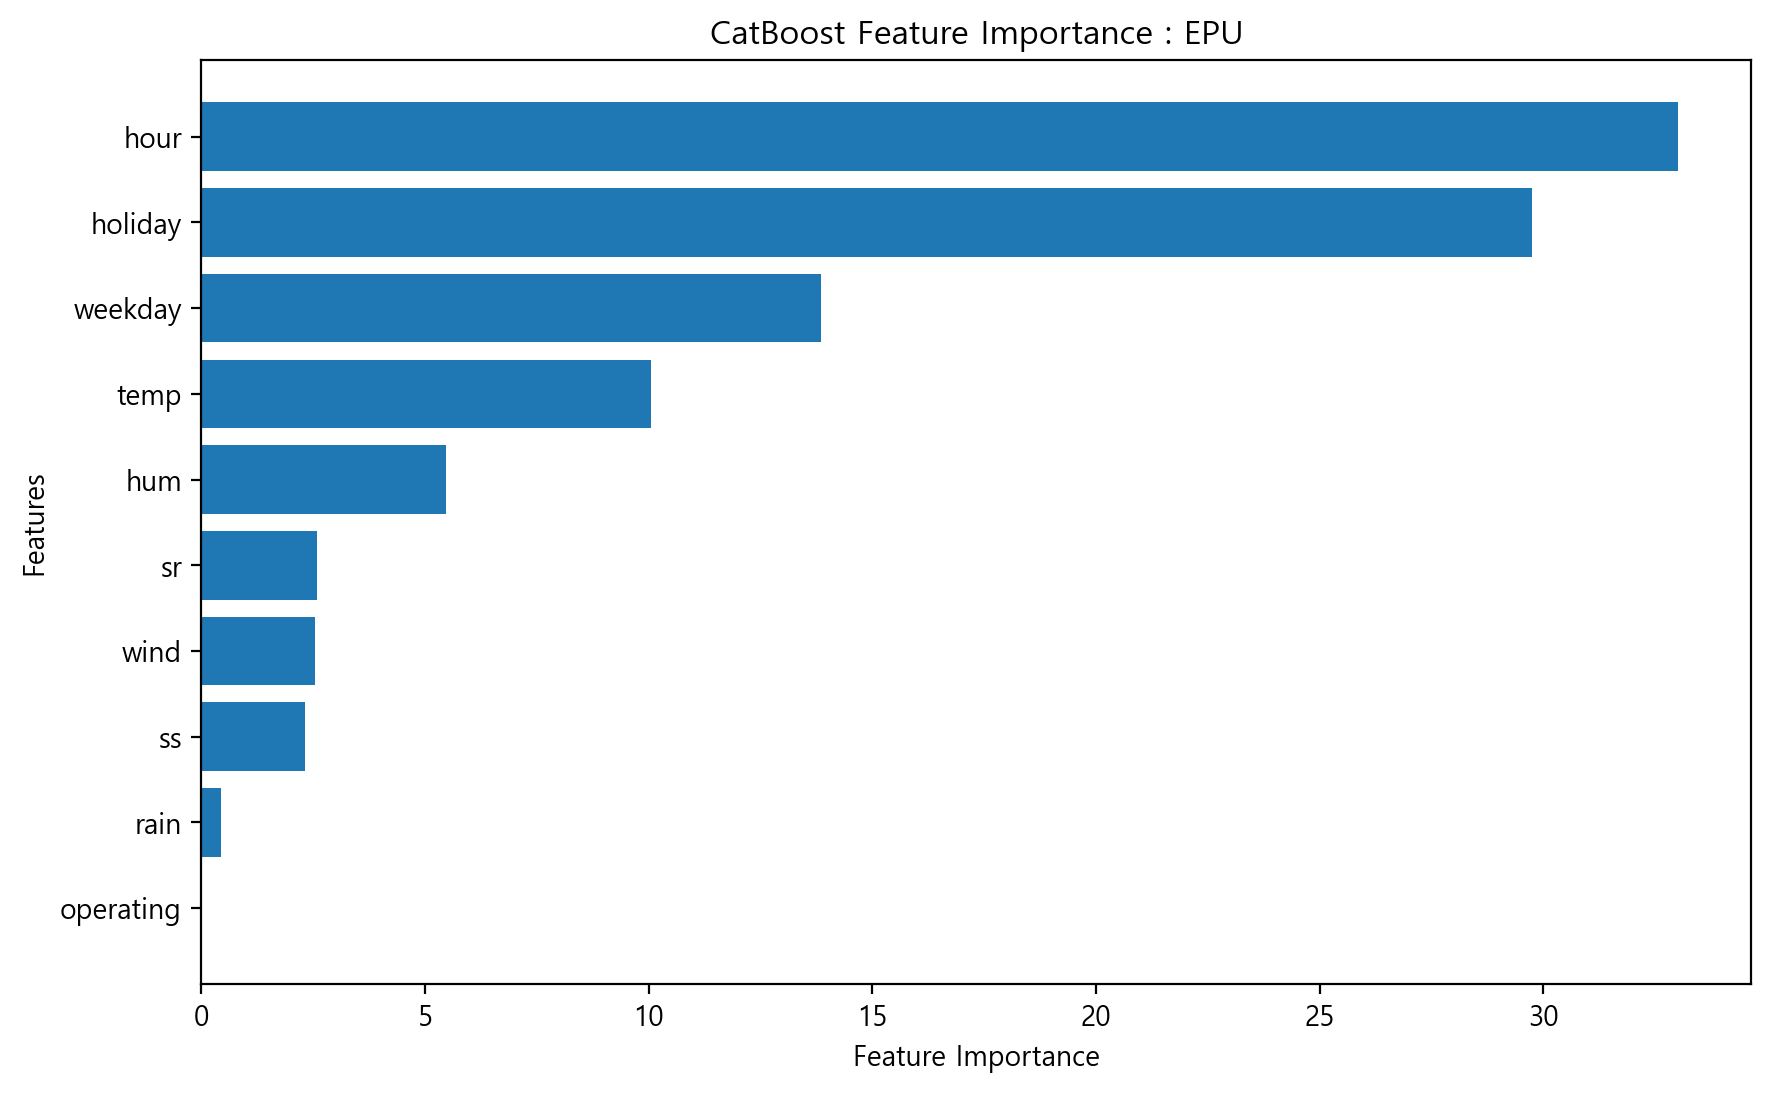

In [64]:
# CatBoostRegressor 모델 초기화
tree_model = CatBoostRegressor(random_state=SEED, verbose=False)

# 모델을 학습 데이터로 학습
tree_model.fit(globals()['X_train_{}'.format(xxx)], globals()['y_train_{}'.format(xxx)])

# 피처 중요도를 얻어옴
feature_importance = tree_model.get_feature_importance()

# 피처명을 가져옴
feature_names = globals()['X_train_{}'.format(xxx)].columns

# 중요도를 데이터프레임으로 변환
fi_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})

# 중요도를 기준으로 내림차순 정렬
fi_df = fi_df.sort_values(by='importance', ascending=False)

# 중요도를 시각화
plt.figure(figsize=(10, 6))
plt.barh(fi_df['feature'], fi_df['importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title(f'CatBoost Feature Importance : {xxx}')
plt.gca().invert_yaxis()  # 중요도가 높은 피처가 위로 오도록 뒤집음
plt.show()


##### ML

###### MODEL

In [65]:
globals()['automl_{}'.format(xxx)] = AutoML(mode="Perform",
                                            algorithms=["CatBoost", "Xgboost", "LightGBM"],
                                            results_path=f"model/DV_{DV}/op_{Operating_yn}/{xxx}",
                                            eval_metric='rmse',
                                            explain_level=0)
globals()['automl_{}'.format(xxx)].fit(globals()['X_train_{}'.format(xxx)], globals()['y_train_{}'.format(xxx)])

This model has already been fitted. You can use predict methods or select a new 'results_path' for a new 'fit()'.


###### CV(RMSE) SCORE

In [66]:
globals()['pred_{}'.format(xxx)] = globals()['automl_{}'.format(xxx)].predict(globals()['X_test_{}'.format(xxx)])
print(f"CV(RMSE) SCORE: {cvrmse_score(globals()['y_test_{}'.format(xxx)], globals()['pred_{}'.format(xxx)])}")

CV(RMSE) SCORE: 17.19843335764839


###### Actual VS Predict lineplot

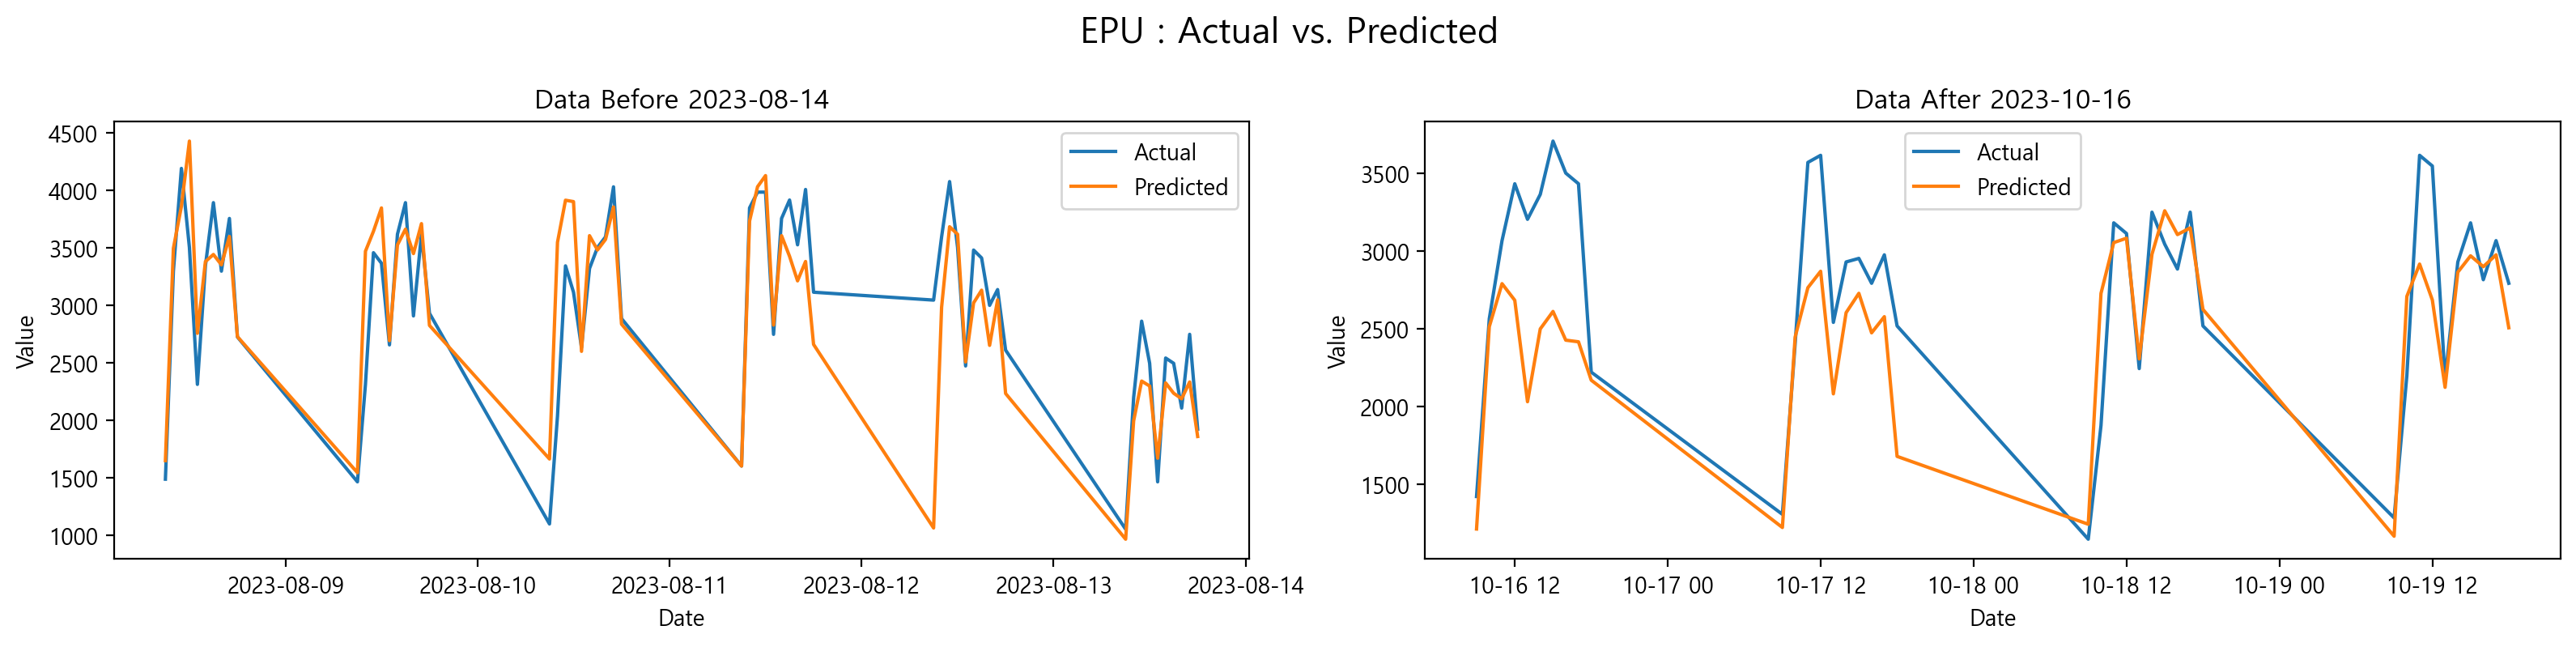

In [67]:
result_df = pd.DataFrame({'useDate': test_useDate, '실제': globals()['y_test_{}'.format(xxx)], '예측': globals()['pred_{}'.format(xxx)]})
before_df = result_df[result_df['useDate'] < '2023-08-15']
after_df = result_df[result_df['useDate'] > '2023-10-16']

Totalfig, axes = plt.subplots(1, 2, figsize=(16 , 4))

axes[0].plot(before_df['useDate'], before_df['실제'], label='Actual')
axes[0].plot(before_df['useDate'], before_df['예측'], label='Predicted')
axes[0].set_title('Data Before 2023-08-14')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Value')
axes[0].legend()

axes[1].plot(after_df['useDate'], after_df['실제'], label='Actual')
axes[1].plot(after_df['useDate'], after_df['예측'], label='Predicted')
axes[1].set_title('Data After 2023-10-16')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Value')
axes[1].legend()

Totalfig.suptitle(f'{xxx} : Actual vs. Predicted', fontsize=16)
plt.tight_layout()
plt.show()


#### sum(useType) vs Total - CV(RMSE) SCORE: 25.598869180428796

In [68]:
xxx = ''

In [69]:
globals()['y_test_{}'.format(xxx)] = test_df[test_df.useType == 'Total']['toeQty']
pred_sum = pred_Cooling + pred_Lighting + pred_EPU
print(f"CV(RMSE) SCORE: {cvrmse_score(globals()['y_test_{}'.format(xxx)], pred_sum)}")

CV(RMSE) SCORE: 20.257112169223856


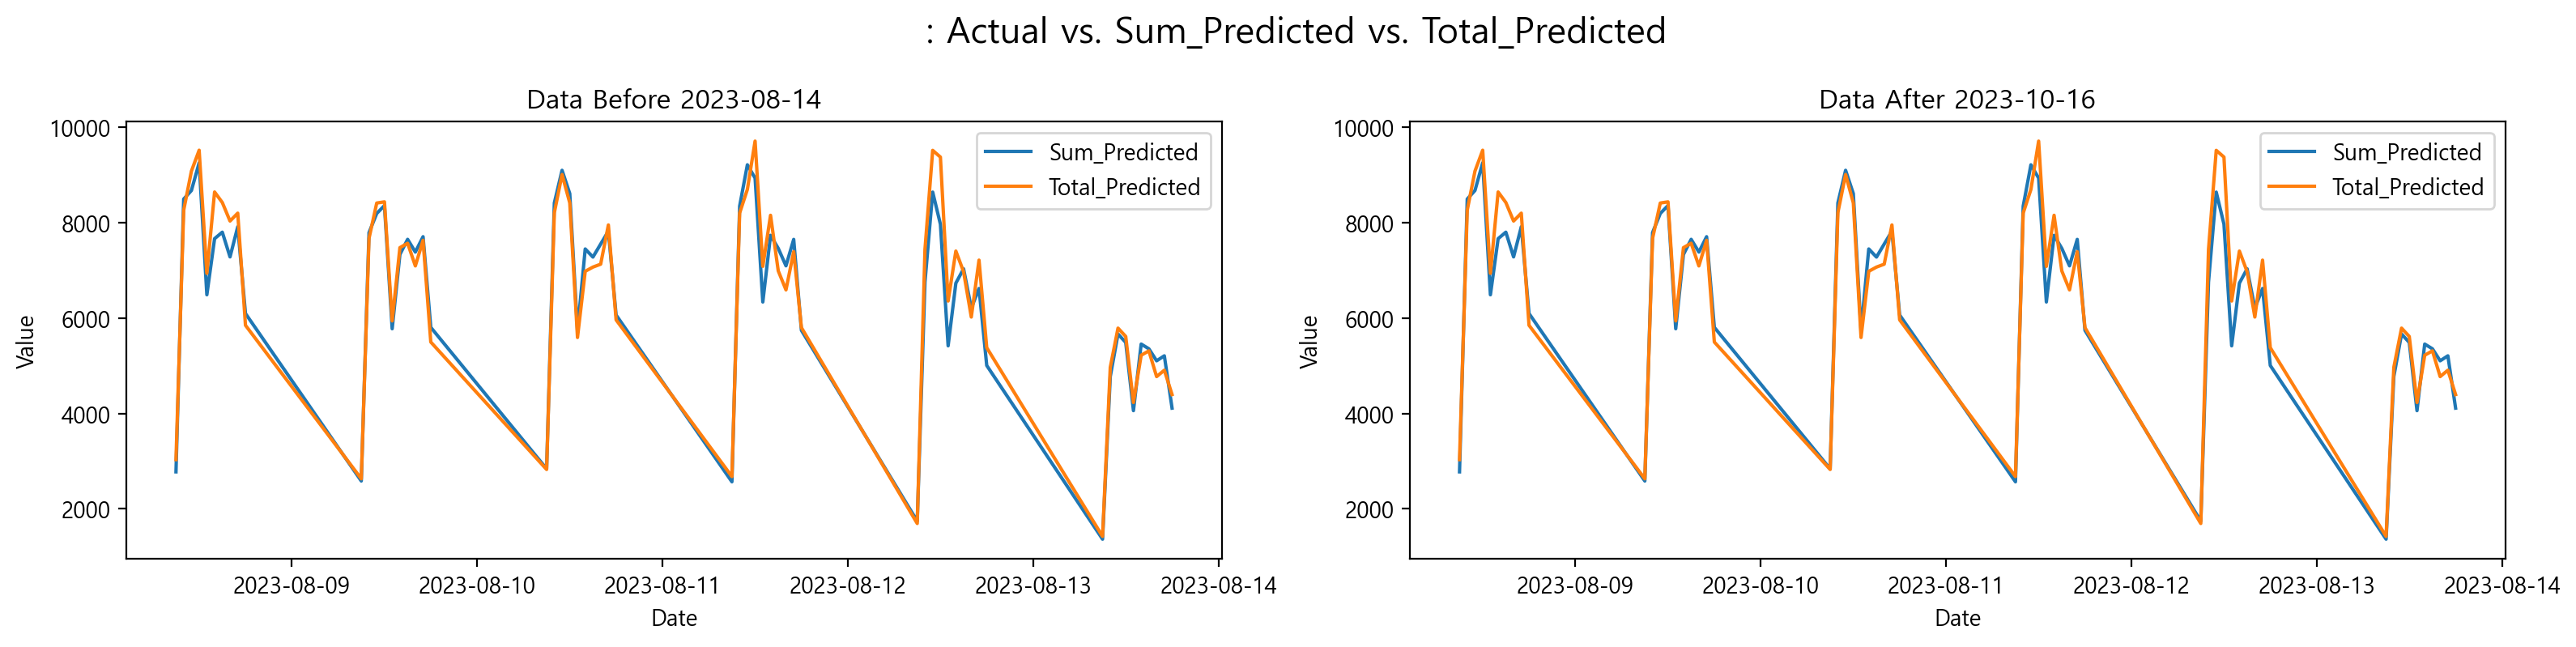

In [70]:
result_df = pd.DataFrame({'useDate': test_useDate.reset_index(drop=True), '실제': y_test_Total.reset_index(drop=True), '부분모델_예측': pred_sum, '통모델_예측' : pred_Total})
before_df = result_df[result_df['useDate'] < '2023-08-15']
after_df = result_df[result_df['useDate'] > '2023-10-16']

fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# axes[0].plot(before_df['useDate'], before_df['실제'], label='Actual')
axes[0].plot(before_df['useDate'], before_df['부분모델_예측'], label='Sum_Predicted')
axes[0].plot(before_df['useDate'], before_df['통모델_예측'], label='Total_Predicted')
axes[0].set_title('Data Before 2023-08-14')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Value')
axes[0].legend()

# axes[1].plot(before_df['useDate'], before_df['실제'], label='Actual')
axes[1].plot(before_df['useDate'], before_df['부분모델_예측'], label='Sum_Predicted')
axes[1].plot(before_df['useDate'], before_df['통모델_예측'], label='Total_Predicted')
axes[1].set_title('Data After 2023-10-16')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Value')
axes[1].legend()

fig.suptitle(f'{xxx} : Actual vs. Sum_Predicted vs. Total_Predicted', fontsize=16)
plt.tight_layout()
plt.show()

In [71]:
result_df

,useDate,실제,부분모델_예측,통모델_예측
0,2023-08-08 09:00:00,2450.3,2775.190365,3031.530550
1,2023-08-08 10:00:00,8335.6,8495.077108,8262.077510
2,2023-08-08 11:00:00,9182.9,8674.581874,9080.467001
3,2023-08-08 12:00:00,7831.8,9255.212224,9518.932537
4,2023-08-08 13:00:00,5404.4,6488.151316,6937.554463
...,...,...,...,...
95,2023-10-19 14:00:00,5358.6,5472.535491,5381.716257
96,2023-10-19 15:00:00,6022.7,5785.195449,5723.594243
97,2023-10-19 16:00:00,5244.1,5462.459214,5719.291881
98,2023-10-19 17:00:00,6137.2,5815.098578,5833.546916


In [75]:
result_df.to_csv(f'data/result/DV_{DV}_op_{Operating_yn}.csv', index=False)